In [170]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [152]:
def get_towers(input_filename):
    df = pd.read_csv(input_filename)
    towers = df[['mcc', 'mnc', 'area_code', 'cell_id']].drop_duplicates().values
    return list(map(tuple, towers))


def get_trajectories(input_filename, towers):
    df = pd.read_csv(input_filename)

    # Create a dictionary to map tower tuples to indices
    tower_to_index = {tuple(tower): i for i, tower in enumerate(towers)}

    # # Convert towers to indices
    df['tower_index'] = df.set_index(['mcc', 'mnc', 'area_code', 'cell_id']).index.map(tower_to_index.get)

    trajectories = {}
    for device, group in df.groupby('device_uuid'):
        group = group.sort_values('time')
        times = group['time'].values
        tower_indices = group['tower_index'].values

        trajectories[device] = {
            'times': times,
            'towers': tower_indices,
            'time_diffs': np.diff(times)
        }

    return {k: v for k, v in trajectories.items() if len(v['times']) > 1}


In [165]:
input_filename = '../zeus-data/zeus_data.csv'
output_filename = '../data.csv'
towers = get_towers(input_filename)
in_trajectories = get_trajectories(input_filename, towers)
out_trajectories = get_trajectories(output_filename, towers)


In [167]:
print(len(in_trajectories), len(out_trajectories))
suim = [i for i in out_trajectories.values()]
print(np.mean([len(i['times']) for i in suim]))
suim = [i for i in in_trajectories.values()]
print(np.mean([len(i['times']) for i in suim]))


194 171
890.7836257309941
4081.639175257732


96.65800214258016 97.06900760041236


/tmp/ipykernel_113100/3259036431.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(o, color='blue', label='Out Trajectories', shade=True)
/tmp/ipykernel_113100/3259036431.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(i, color='green', label='In Trajectories', shade=True)


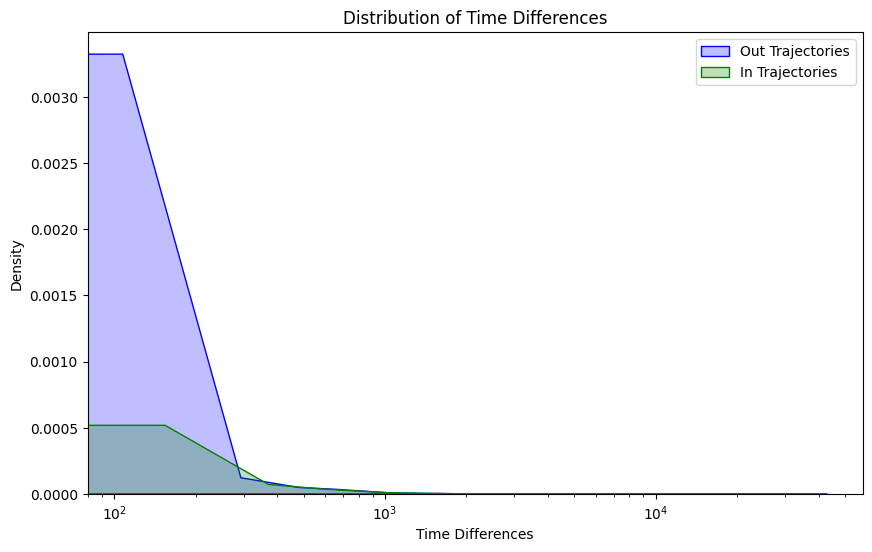

In [173]:
o = np.concatenate([i['time_diffs'] for i in out_trajectories.values()])
i = np.concatenate([i['time_diffs'] for i in in_trajectories.values()])
i = i[i<12*60*60]
print(np.mean(o),np.mean(i))

# Plotting the KDE for 'o' and 'i'
plt.figure(figsize=(10, 6))

sns.kdeplot(o, color='blue', label='Out Trajectories', shade=True)
sns.kdeplot(i, color='green', label='In Trajectories', shade=True)

# Adding titles and labels
plt.title('Distribution of Time Differences')
plt.xlabel('Time Differences')
plt.xscale('log')
plt.ylabel('Density')
plt.legend()

plt.show()


In [180]:
o = np.concatenate([i['times'] for i in out_trajectories.values()])
i = np.concatenate([i['times'] for i in in_trajectories.values()])
print((o.max()-o.min()) / (60*60*24))
print((i.max()-i.min()) / (60*60*24))

0.999988425925926
27.96560185185185


In [114]:
def get_tower_avg_signal_duration(trajectories, num_towers):
    durations = np.zeros(num_towers)
    counts = np.zeros(num_towers)
    for trajectory in trajectories.values():
        for i in range(len(trajectory['times'])-1):
            if trajectory['time_diffs'][i] < 60 * 60:
                tower = trajectory['towers'][i]
                durations[tower] += trajectory['time_diffs'][i]
                counts[tower] += 1
    with np.errstate(divide='ignore', invalid='ignore'):
        avg_durations = np.divide(durations, counts, out=np.zeros_like(durations), where=counts != 0)
    return avg_durations, counts
        

In [133]:
num_towers = len(towers)
all_durations, all_counts = get_tower_avg_signal_duration(in_trajectories | out_trajectories, num_towers)
d_durations = np.array([get_tower_avg_signal_duration({1: i}, num_towers)[0] for i in in_trajectories.values() if len(i['times']) > 100])
synth_durations = np.array([get_tower_avg_signal_duration({1: i}, num_towers)[0] for i in out_trajectories.values() if len(i['times']) > 100])

In [140]:
count_filter = np.where(all_counts > 100)

all_durations_f = all_durations[count_filter]
d_durations_f = np.array([i[count_filter] for i in d_durations])
synth_durations_f = np.array([i[count_filter] for i in synth_durations])

d_std = np.array([np.std(i) for i in d_durations_f])
synth_std = np.array([np.std(i) for i in synth_durations_f])

print(d_std.min(), d_std.max(), d_std.mean(), d_std.std())
print(synth_std.min(), synth_std.max(), synth_std.mean(), synth_std.std())

synth_sorted = -np.sort(-synth_std)
d_sorted = -np.sort(-d_std)

print(synth_sorted)
print(d_sorted)

np.searchsorted(-synth_sorted, -d_sorted)



1.0939048975360472 69.41336407553828 21.871836349394396 16.656148472562535
5.5744395782840215 102.87784409926354 51.354337077441016 14.092060253907079
[102.8778441   96.18615257  92.23385293  90.95048579  89.82277818
  89.51620856  89.35233229  88.81817146  88.61710416  87.25450836
  86.31538043  86.17308676  84.74430086  84.70096673  84.34543847
  84.18684379  83.84516674  83.31516887  82.94383472  82.85108759
  82.84511411  82.31689373  81.7974803   81.3173236   81.26018133
  80.81987577  80.62824455  80.51782096  80.50741071  79.93789702
  79.19122863  79.15686941  79.05612943  78.9201274   78.84597063
  78.52836509  78.41629991  78.40547008  77.87416935  77.7193153
  77.6988319   77.58422947  77.39792225  75.96525031  75.43858257
  75.21364246  75.18457858  75.13601721  74.9272651   74.84383909
  74.73316909  74.68382786  74.62929001  74.16765169  73.82224063
  73.81824495  73.74565221  73.44435301  73.39539487  73.07752183
  72.9326098   72.90968278  72.89854842  72.85023717  72.8

array([  92,  240,  323,  447,  456,  517,  601,  678,  682,  746,  781,
        796,  802,  848,  854,  856,  856,  876,  880,  881,  881,  893,
        908,  915,  928,  930,  931,  940,  940,  942,  942,  946,  949,
        951,  952,  952,  956,  956,  961,  962,  963,  970,  970,  970,
        971,  971,  972,  972,  972,  973,  974,  974,  974,  975,  979,
        981,  981,  981,  981,  986,  989,  989,  989,  989,  992,  995,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

In [65]:
# Attempt to identify using stdev of durations
failed = 0
for uuid, trajectory in in_trajectories.items():
    if np.std(get_tower_avg_signal_duration({uuid: trajectory}, num_towers)[0]) < 50:
        failed += 1
print(failed / len(in_trajectories))
failed = 0
for uuid, trajectory in out_trajectories.items():
    if np.std(get_tower_avg_signal_duration({uuid: trajectory}, num_towers)[0]) > 50:
        failed += 1
print(failed / len(out_trajectories))

0.7017543859649122
0.134


In [87]:
def towers_at_four_am(trajectory):
    day = 24 * 60 * 60
    first = (trajectory['times'][0] + day) // day * day
    values = np.arange(first, trajectory['times'][-1], day)
    indices = np.searchsorted(trajectory['times'], values)
    return trajectory['towers'][np.unique(indices)]

in_bed = [towers_at_four_am(i) for i in in_trajectories.values()]
out_bed = [towers_at_four_am(i) for i in out_trajectories.values()]
in_bed = [i for i in in_bed if len(i) > 0]
out_bed = [i for i in out_bed if len(i) > 0]

print(np.mean([np.unique(i, return_counts=True)[1][0] / len(i) for i in in_bed]))
print(np.mean([np.unique(i, return_counts=True)[1][0] / len(i) for i in out_bed]))


0.41668281899260157
0.11584444444444447


(1171, 11984)


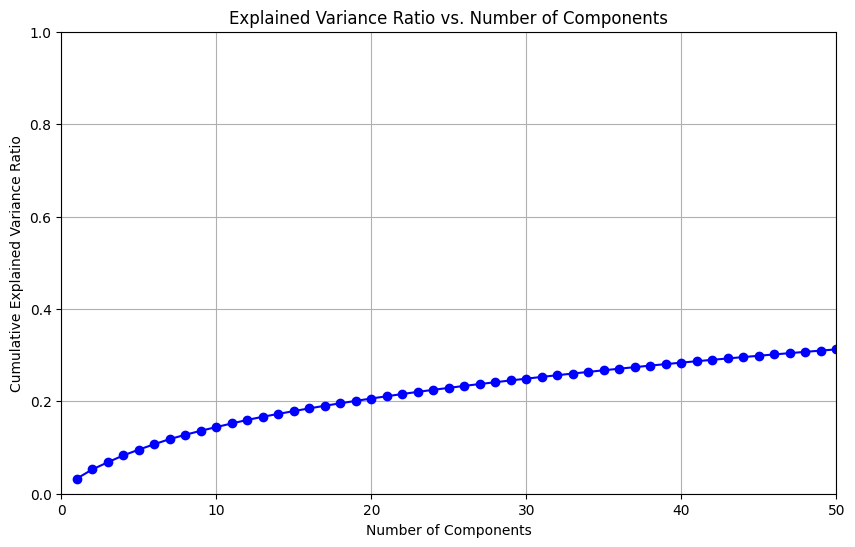

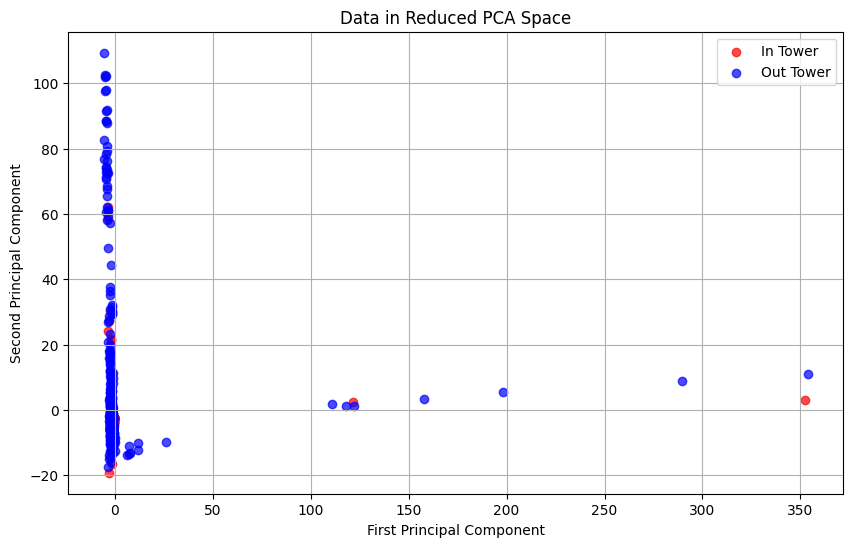

Explained variance ratio: [0.03266806 0.0199009 ]
Cumulative explained variance ratio: 0.052568962844244435


In [106]:
# Your data is already in the correct shape
all_durations = np.array(in_tower_durations + out_tower_durations)
print(all_durations.shape)

# Standardize the data
scaler = StandardScaler()
dur_scaled = scaler.fit_transform(all_durations)

# Perform initial PCA to analyze explained variance
pca_full = PCA()
pca_full.fit(dur_scaled)

cumulative_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)

# Plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.xlim(0, 50)  # Limit x-axis to first 50 components for better visibility
plt.ylim(0, 1)   # Set y-axis from 0 to 1
plt.grid(True)
plt.show()

# Choose the number of components (e.g., 2 for visualization)
n_components = 2
pca = PCA(n_components=n_components)
all_pca_reduced = pca.fit_transform(dur_scaled)

# Split the reduced data back into in-tower and out-tower
n_in = len(in_tower_durations)
in_pca_reduced = all_pca_reduced[:n_in]
out_pca_reduced = all_pca_reduced[n_in:]

# Plot the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(in_pca_reduced[:, 0], in_pca_reduced[:, 1], color='red', label='In Tower', alpha=0.7)
plt.scatter(out_pca_reduced[:, 0], out_pca_reduced[:, 1], color='blue', label='Out Tower', alpha=0.7)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Data in Reduced PCA Space')
plt.legend()
plt.grid(True)
plt.show()

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:", sum(pca.explained_variance_ratio_))